# **Arms Trade: Clustering**

## Objectives

* The goal of this notebook is to cluster countries based on their trade behaviour 
* I hope to discover 3 clusters: Major Importer, Major Exporter and Balanced Trader

## Inputs

* Like the last section, this notebook requires the processed dataset 'arms_trade_cleaned.csv' as found in the data_folder/Processed path

## Outputs

* First and foremost a ML clustering pipeline will be produced
* Following on from this a small dataframe will be created to join the cluster labels to the main dataset 




---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\jackr\\OneDrive\\Desktop\\my_projects\\Capstone\\Arms-Import-Export-Analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\jackr\\OneDrive\\Desktop\\my_projects\\Capstone\\Arms-Import-Export-Analysis'

# Preprocessing and Scaling

In this section the features for the pipeline will be chosen and necessary scaling and processing steps will be applied

Importing the necessary libraries.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

Retrieving dataset

In [5]:
arms_enhance_df = pd.read_csv('data_folder/Processed/arms_trade_cleaned.csv')
arms_enhance_df.head()

,OrderDate,TransactionID,Recipient,Supplier,Number ordered,Weapon designation,Weapon description,Number delivered,status,Comments,SIPRI TIV per unit,SIPRI TIV for total order,SIPRI TIV of delivered weapons,Supplier_Total_TIV,Recipient_Total_TIV,Trade_Volume,Decade,Trade_Frequency
0,2002-01-01,Russia_2002.0_0,Afghanistan,Russia,3.0,Mi-17,transport helicopter,3.0,Second hand,Second-hand; aid,2.90,8.70,8.70,165817.26,15809.14,11,2000.0,6
1,2007-01-01,Turkiye_2007.0_1,Afghanistan,Turkiye,24.0,M-114 155mm,towed gun,24.0,Second hand,Second-hand; aid,0.20,4.80,4.80,6689.54,15809.14,1,2000.0,1
2,2004-01-01,United States_2004.0_2,Afghanistan,United States,188.0,M-113,armoured personnel carrier,188.0,Second hand,Second-hand; aid; M-113A2 version; incl 15 M-5...,0.10,18.80,18.80,849588.93,15809.14,34,2000.0,3
3,2016-01-01,United States_2016.0_3,Afghanistan,United States,53.0,S-70 Black Hawk,transport helicopter,53.0,Second hand but modernized,Second-hand UH-60A modernized to UH-60A+ befor...,4.29,227.37,227.37,849588.93,15809.14,34,2010.0,31
4,1973-01-01,Soviet Union_1973.0_4,Afghanistan,Soviet Union,100.0,T-62,tank,100.0,New,No additional info,1.80,180.00,180.00,452121.07,15809.14,82,1970.0,25


Choosing features and assigning to X.

It was discovered in the last section that Trade_Volume vs Trade Frequency had promise for clusters, the addition of Supplier and Reciepient TIV is a natural addition as all these features correlate heavily.

In [6]:
features = [
    'Supplier_Total_TIV',
    'Recipient_Total_TIV',
    'Trade_Volume',
    'Trade_Frequency'
]

X = arms_enhance_df[features]


It was also concluded in the statistical analysis section of the last notebook that the data was heavily right skewed, so it was decided that for future modelling a log scale would make the data easier to work with.

In [7]:
# Log transform to noramlise right skew distribution
X_log = np.log1p(X)

# Standardized for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)


Next the optimal number of clusters will be calculated with 2 scoring methods, the hope is for 3 clusters nut if the scoring determines otherwise adjustments can be made.

c:\Users\jackr\OneDrive\Desktop\my_projects\Capstone\Arms-Import-Export-Analysis\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jackr\OneDrive\Desktop\my_projects\Capstone\Arms-Import-Export-Analysis\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jackr\OneDrive\Desktop\my_projects\Capstone\Arms-Import-Export-Analysis\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_

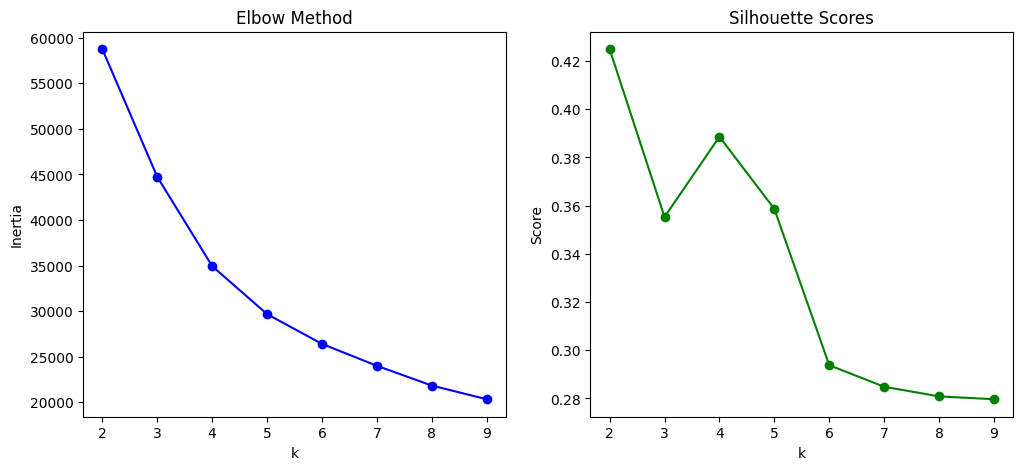

In [8]:
inertia = []
silhouette = []
K = range(2, 10)

# for loop to calculate inertia and silhouette scores
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow and silhouette
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(K, inertia, 'o-', color='blue')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')

ax[1].plot(K, silhouette, 'o-', color='green')
ax[1].set_title('Silhouette Scores')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Score')

plt.show()


This is a brilliant and clear result. In the Elbow Method it's apparent the elbow starts forming around 4 k with a pronounced plateau around at 5 k and above. In the Silhouette Plot 2 k Has the score but there's an obvious peak formed again at 4 k. From this it can't be ignored that 4 clusters is the optimal number as both tests confirm this. While this is different from my expected 3 clusters it actually makes more sense, as opposed to just Importers, Exporters and Balanced, 4 clusters correctly identifies the existence of countries who have minimal interaction with the arms trade altogether.

---

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create your folder here
  # os.makedirs(name='')
except Exception as e:
  print(e)
